## Convective/Stratiform identification for 3D Reflectivity from derived dBZ of WRF Simulations. 

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20210930**

In [1]:
%reset

import sys
from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
from scipy.interpolate import interpn
import xarray as xr
import pandas as pd
import wrf
from wrf import (getvar, vinterp, interplevel, extract_times, destagger, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib as mpl
import matplotlib.pyplot as plt

# import metpy
# import metpy.calc as mpcalc
# import metpy.units as units
# print(metpy.__version__)
# import dask


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


**Set input files paths and names:**

In [2]:
def set_input_names(file_date):

    file_path_1 = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1 
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

wrf_sim_type = 'CTRL3D'
file_name_list = set_input_names(dt.datetime(2013,9,13))
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/2013/wrf3d_d01_CTRL_dbz_20130913.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2013/wrf3d_d01_CTRL_Z_20130913.nc'}


**Deploy wrf.interplevel directly:**

In [3]:
# wrf_dbz = getvar(ncds_wrf_dbz, 'dBZ', meta=False)

ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=0)

data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=0, meta=False), 0)

interp_vertical_lev = [2500] # meter inheight.

dbz_lev = interplevel(da_wrf_dbz, data_wrf_z_unstag, interp_vertical_lev)


**Save interpolated field to temporary file:**

In [4]:
# dbz_lev = dbz_lev.assign_attrs(vert_units='m')
# dbz_lev.to_netcdf('/glade/scratch/hungjui/temp/tmp_dbz_lev.nc')
# write_xarray_to_netcdf(dbz_lev, '/glade/scratch/hungjui/temp/tmp_dbz_lev.nc')

### Test plot:

**Set colorbars:**

In [5]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
# clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

**Function: creating new map:**

In [12]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Grab state borders:
    state_borders = NaturalEarthFeature(category='cultural', 
                                        name='admin_1_states_provinces_shp', 
                                        scale='110m', 
                                        facecolor='none'
                                       )
    ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)
    
    ## Add coast lines:
    ax.coastlines('110m', 'black', linewidth=1)
    
    # Add the gridlines
    ax.gridlines(color="black", linestyle="dotted")
    
    # ax.set_global()
    
    return ax

**Do the plot:**

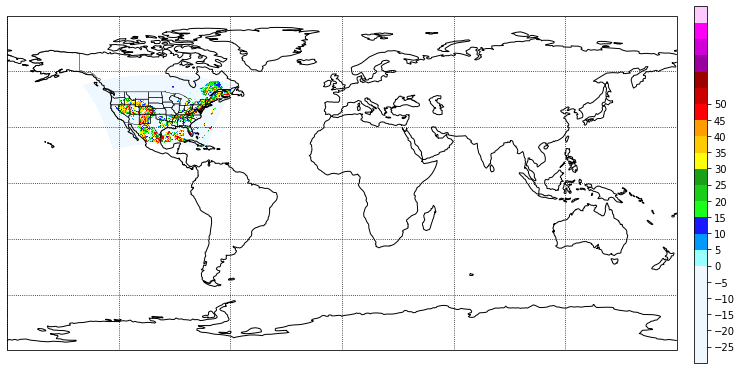

In [13]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = dbz_lev.data
plotting_lon = dbz_lev.XLONG
plotting_lat = dbz_lev.XLAT

cf = ax1.contourf(plotting_lon, plotting_lat, plotting_var, levels=clevs, colors=ccols)

cbar_ax = fig.add_axes([0.92, 0.225, 0.015, 0.55])
cbar = fig.colorbar(cf, cax=cbar_ax, ticks=clevs[1:17], fraction=0.04)

# dbz_lev.plot(ax=ax1, transform = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# dbz_lev.plot(ax=ax1, transform=ccrs.PlateCarree())
# dbz_lev.plot(ax=ax1)

# Set the map bounds:
# ax1.set_xlim(-120, -80)
# ax1.set_ylim(20, 60)


## NWS colorbar:

# cf = ax1.pcolormesh(dbz_lev.XLONG, dbz_lev.XLAT, dbz_lev, cmap=ref_cmap, norm=ref_norm, zorder=0)

# ax1.coastlines('10m', 'black', linewidth=2, zorder=2)

# cbar_ax = fig.add_axes([0.9, 0.225, 0.015, 0.55])
# cbar = fig.colorbar(cf, cax=cbar_ax)


## CWB colorbar:

# ax1.set_global()

# ## add coast lines:
# ax1.coastlines('110m', 'black', linewidth=2, zorder=2)
# ## Grab state borders:
# state_borders = NaturalEarthFeature(category='cultural', 
#                                     name='admin_1_states_provinces_lines', 
#                                     scale='110m', 
#                                     facecolor='none'
#                                    )
# ax1.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)

# lats, lons = latlon_coords(dbz_lev)
# cf = ax1.contourf(to_np(lons), to_np(lats), to_np(dbz_lev), levels=clevs, colors=ccols, transform=ccrs.LambertConformal(), zorder=1)

# cbar_ax = fig.add_axes([0.8, 0.225, 0.015, 0.55])
# cbar = fig.colorbar(cf, cax=cbar_ax, ticks=clevs[1:17], fraction=0.04)


# plt.title(datetime.utcnow())

In [27]:
# lats, lons = latlon_coords(dbz_lev)

# fig = plt.figure(figsize=(12,6))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ## Download and add the states and coastlines
# # states = NaturalEarthFeature(category="cultural", scale="50m",
# #                              facecolor="none",
# #                              name="admin_1_states_provinces_shp")
# # ax.add_feature(states, linewidth=.5, edgecolor="black")
# ax.coastlines('50m', linewidth=0.8)

# plt.pcolor(to_np(lons), to_np(lats), to_np(dbz_lev),
#            transform=ccrs.LambertConformal()
#           )

In [22]:
# dbz_lev.plot()

In [78]:
# print(ncds_wrf_dbz)
# print(ncds_wrf_z.dimensions)
# print(type(data_wrf_z_unstag))
# print(wrf_dbz)
# dbz_lev
# latlon_coords(dbz_lev)
# get_cartopy(dbz_lev)
# print(dbz_lev.Time)

<xarray.DataArray 'Time' ()>
array('2013-09-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2013-09-13
    level    int64 2500
Attributes:
    long_name:    Time
    description:  Time


<del>**Function: write xarray dataarray to netcdf:**</del>

In [12]:
def write_xarray_to_netcdf(xarray_array, output_path,mode='w', format='NETCDF4', group=None, engine=None,
                           encoding=None):
    """
    writes and xarray in a netcdf format outputfile
    Uses the xarray typical for wrf-python. The projection objects are transformed into strings
    to be able to use them as netcdf attributes
    :param xarray_array: xarray.DataArray
    :param output_path: str
    :param format: 'NETCDF4', 'NETCDF4_CLASSIC', 'NETCDF3_64BIT' or 'NETCDF3_CLASSIC'
                    default: 'NETCDF4'
    :param group: str, default None
    :param engine: 'netcdf4', 'scipy' or 'h5netcdf'
    :param encoding: dict, default: None
    """

    xarray_array_out = xarray_array.copy(deep=True)
    # coordinates are extracted from variable:
    # del xarray_array_out.attrs['coordinates']
    # wrf-python projection object cannot be processed:
    # xarray_array_out.attrs['projection'] = str(xarray_array_out.attrs['projection'])

    xarray_array_out.to_netcdf(path=output_path, mode=mode, format=format, group=group,
                               engine=engine,
                               encoding=encoding)

<del>**Test inserting Z into Netcdf4 dataset:**</del>

In [29]:
# # ncds_wrf_dbz = Dataset(file_name_list['dbz'], 'a') # , format="NETCDF4")

# tmp_wrf_data = '/glade/scratch/hungjui/temp/tmp_wrf_dbz.nc'
# copyfile(file_name_list['dbz'], tmp_wrf_data)
# ncds_wrf_dbz = Dataset(tmp_wrf_data, 'a')

# ncds_wrf_z = Dataset(file_name_list['Z'])
# data_wrf_z_unstag = wrf.destagger(getvar(ncds_wrf_z, 'Z', timeidx=wrf.ALL_TIMES, meta=False), 1)
# ncds_wrf_z.close()

# GEO_H = ncds_wrf_dbz.createVariable('Z', 'f4', ('Time', 'bottom_top', 'south_north', 'west_east'))
# GEO_H[:] = data_wrf_z_unstag

# ncds_wrf_dbz.close()

<del>**Test inserting Z into Netcdf4 dataset (read multiple files at once):
NOT WORKING!**</del>

In [87]:
# file_names = [ file_name_list['dbz'], file_name_list['Z'] ]
# ncds_wrf_dbz_z = MFDataset(file_names)

<del>**Test interpolation with xarray data array:**</del>

In [3]:
# ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])

# data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=0, meta=False), 0)
# # print(ds_wrf_z_unstag.shape)
# # print(type(da_wrf_z_unstag))

# da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=0).assign_coords(GEO_H=(('bottom_top','south_north','west_east'), data_wrf_z_unstag))

# # da_wrf_dbz = xr.DataArray( ds_wrf_dbz['dBZ'].isel(Time=0), {'GEO_H': (('bottom_top','south_north','west_east'), da_wrf_z_unstag)} )

# # da_wrf_dbz

**Get wrf output variables:**

In [58]:
def get_wrf_vars(file_name, var_name, time_index):

    wrf_file = Dataset(file_name)
    # wrf_var = getvar(wrf_file, wrf_var_to_read, timeidx=time_index_1) # This doesn't work for CONUS run files.
    wrf_var = getvar(wrf_file, var_name, timeidx=time_index, meta=False)
    # wrf_var_time = wrf.extract_times(wrf_file, timeidx=time_index)
    # print(wrf_var_time)
    
    return wrf_var

**Set output file path and name:**

In [5]:
def set_output_name(output_file_datetime):

    # output_path = '/glade/u/home/hungjui/2scratch/DATA_WRF_CONUS_1_dBZ_v1.0'
    
    output_time = pd.to_datetime(output_file_datetime).strftime('%Y%m%d') # If input time type is numpy.datetime64:
    
    # output_name = output_path + '/wrf3d_d01_dbz_{}.nc'.format(file_date_time.strftime('%Y%m%d%H'))
    # output_name = output_path + '/wrf3d_d01_dbz_{}.nc'.format(output_time)
    output_name = '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(output_time)

    return output_name


### Main Function:

In [6]:
def main_function(file_date_time):
    
    ## Set file datetime:
    # file_date_time = dt.datetime(2013, 9, 13, 0, 0, 0, tzinfo=pytz.utc)
    print('Processing: {}'.format(file_date_time.strftime('%Y%m%d')), end=' ')
    
    ## Set input files paths and names:
    file_name_dict = set_input_names(file_date_time)

    ## Get the 3-hourly time list from P and QRAIN files:
    wrf_3hour_list_1 = wrf.extract_times(Dataset(file_name_dict['P']), timeidx=wrf.ALL_TIMES, meta=False, do_xtime=False)
    wrf_3hour_list_2 = wrf.extract_times(Dataset(file_name_dict['QRAIN']), timeidx=wrf.ALL_TIMES, meta=False, do_xtime=False)

    ## Set wrf variable list for reflectivity retrieval:
    wrf_vars_list = ['P', 'TK', 'QVAPOR', 'QRAIN', 'QSNOW', 'QGRAUP']

    ## Set dBZ data array and append calculated data:
    # wrf_dbz = xr.zeros_like(wrf_dataset_out['P'])
    
    for hi in range(len(wrf_3hour_list_1)):
        
        print(str(hi) + ' | ', end=' ')

        ## Get the index for common time in different files (every 3-hour):
        common_index_2 = np.intersect1d(wrf_3hour_list_1[hi], wrf_3hour_list_2, return_indices=True)[2][0]

        ## Get wrf output variables:
        wrf_vars = {}
        for vname in wrf_vars_list:

            file_name = file_name_dict[vname]

            if ( vname in ['QRAIN', 'QGRAUP'] ):
                wrf_vars['{}'.format(vname)] = get_wrf_vars(file_name, vname, common_index_2)
                # wrf_vars['{}'.format(vname)] = xr.open_dataset(file_name)
            else:
                wrf_vars['{}'.format(vname)] = get_wrf_vars(file_name, vname, hi)
                # wrf_vars['{}'.format(vname)] = xr.open_dataset(file_name)


        ## Calculation for dBZ:
        wrf_dbz_3hr = calculate_wrf_dbz(wrf_vars['P'],
                                        wrf_vars['TK'], 
                                        wrf_vars['QVAPOR'],
                                        wrf_vars['QRAIN'],
                                        wrf_vars['QSNOW'],
                                        wrf_vars['QGRAUP']
                                        ) # .to_dataset()
        
        # wrf_dbz_3hr = wrf_dbz_3hr.expand_dims({'TimeDim': 8})
        # print(wrf_dbz_3hr)
        
        if ( hi == 0 ):
            wrf_dbz = wrf_dbz_3hr
        else:
            wrf_dbz = xr.concat([wrf_dbz, wrf_dbz_3hr], dim='TimeDim')

    # print(wrf_dbz)
            
    ## Set output dataset:
    wrf_dataset_out = xr.open_dataset(file_name_dict['P'])    
      
    ## Add dBZ to output dataset:
    wrf_dataset_out['dBZ'] = (['Time', 'bottom_top', 'south_north', 'west_east'], wrf_dbz)
    #print(wrf_dataset_out)
    
    ## Drop P from the output dataset:
    wrf_dataset_out = wrf_dataset_out.drop_vars('P')
            
    ## Unstagger Z vertical grids:
    # wrf_var_Z_unstag = wrf.destagger(getvar(Dataset(file_name_dict['Z']), 'Z', timeidx=hi, meta=False), 0)

    ## Get AGL:
    # wrf_var_Z_AGL = wrf.g_geoht.get_height_agl(Dataset(file_name_dict['Z']), 'Z', meta=False)

    ## Add Z and dBZ into dataset of P:
    # wrf_dataset_P_Z_dBZ = xr.open_dataset(file_name_dict['P']).isel(Time = hi)
    # wrf_dataset_out = xr.open_dataset(file_name_dict['P'])
    # wrf_dataset_out['dBZ'] = (['bottom_top', 'south_north', 'west_east'], wrf_dbz)
    
    # wrf_dataset_P_Z_dBZ['TK'] = (['bottom_top', 'south_north', 'west_east'], wrf_vars['TK'])
    # wrf_dataset_P_Z_dBZ['Z'] = (['bottom_top', 'south_north', 'west_east'], wrf_var_Z_unstag)
        
    ## Calculate Z using the U.S. standard atmosphere & Hypsometric eqn.:
    # Z_standard = mpcalc.pressure_to_height_std((wrf_dataset_P_Z_dBZ['P'].values) * units.units.Pa)
    # wrf_dataset_P_Z_dBZ['Z_standard'] = (['bottom_top', 'south_north', 'west_east'], Z_standard)

    ## Set coordinates and dimensions:

    ## Set output file path and name:
    output_path_1 = '/glade/u/home/hungjui/2scratch/DATA_WRF_CONUS_1_dBZ_v1.0/' + wrf_sim_type
    # output_path_2 = '/20130913'
    output_path_2 = '/{}'.format(file_date_time.strftime('%Y'))
    output_file_name = set_output_name(file_date_time)
    wrf_dataset_out.to_netcdf(output_path_1 + output_path_2 + output_file_name)
        
    print('Finish this date.')
        

### Main Program:

In [7]:
start = time.time()

## WRF Model Simulation Category:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Loop through a period:
target_date_range = pd.date_range(start='2005-12-27', end='2005-12-31', tz=pytz.utc)

for dayi in target_date_range:
    
    main_function(dayi)
    #main_calc = delayed(main_function)(dayi)
    
# main_calc.compute()
# main_calc.visualize()

end = time.time()
print("RUNTIME：%f SEC" % (end - start))
print("RUNTIME：%f MIN" % ((end - start)/60))
print("RUNTIME：%f HOUR" % ((end - start)/3600))

Processing: 20051227 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  Finish this date.
Processing: 20051228 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  Finish this date.
Processing: 20051229 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  Finish this date.
Processing: 20051230 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  Finish this date.
Processing: 20051231 0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 |  Finish this date.
RUNTIME：1141.574093 SEC
RUNTIME：19.026235 MIN
RUNTIME：0.317104 HOUR


In [73]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
